In [1]:
from multiprocessing.connection import wait
import os
from PIL import Image

import numpy as np
import pandas as pd

from sklearn.utils import shuffle
import random
random.seed(10)


from cv2 import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf


import keras
import matplotlib.cm as cm

from keras_unet.utils import plot_segm_history

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


LEN:  3966
Cats len:  1000
Dogs len:  1000
Pizza len:  983
Not Pizza len:  983


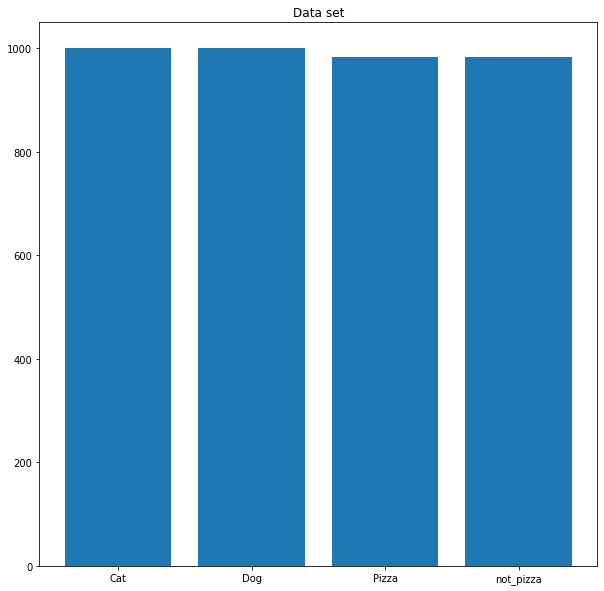

In [2]:
path_train = r"C:\Users\Odin\Desktop\Cats&Dogs&Pizza\dataset\set"
levels = ['cats', 'dogs', 'pizza', 'not_pizza']
data = []
data_dir = os.path.join(path_train)

for i, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(
    data, columns=['image_file', 'pet_or_pizza_or_not'])

data['path'] = path_train + '/' + data['image_file']
data['pet_or_pizza_or_not'] = data['pet_or_pizza_or_not'].map(
    {'cats': 'cat', 'dogs': 'dog', 'pizza': 'Pizza', 'not_pizza': 'not_Pizza'})

#print("Data: ", data)
print("LEN: ", len(data))
print("Cats len: ", len(
    data[data['pet_or_pizza_or_not'] == 'cat']))
print("Dogs len: ", len(
    data[data['pet_or_pizza_or_not'] == 'dog']))
print("Pizza len: ", len(
    data[data['pet_or_pizza_or_not'] == 'Pizza']))
print("Not Pizza len: ", len(
    data[data['pet_or_pizza_or_not'] == 'not_Pizza']))

freq = [len(data[data['pet_or_pizza_or_not'] == 'cat']), len(data[data['pet_or_pizza_or_not'] == 'dog']), len(
    data[data['pet_or_pizza_or_not'] == 'Pizza']), len(data[data['pet_or_pizza_or_not'] == 'not_Pizza'])]

plt.figure(figsize=(10, 10))
plt.bar(["Cat", "Dog", "Pizza", "not_pizza"], freq)
plt.title("Data set")
plt.show()


In [3]:
df = []

for i in range(len(data)):
    images = cv2.imread(data['path'][i])
    images = cv2.resize(images, (128,128))
    if data['pet_or_pizza_or_not'][i] == "cat":
        pet_or_pizza_or_not = np.array([1, 0, 0, 0])
    elif data['pet_or_pizza_or_not'][i] == "dog":
        pet_or_pizza_or_not = np.array([0, 1, 0, 0])
    elif data['pet_or_pizza_or_not'][i] == "Pizza":
        pet_or_pizza_or_not = np.array([0, 0, 1, 0])
    elif data['pet_or_pizza_or_not'][i] == "not_Pizza":
        pet_or_pizza_or_not = np.array([0, 0, 0, 1])
    else:
        pet_or_pizza_or_not = 3
    df.append([images, pet_or_pizza_or_not])

In [4]:
x = []
y = []

for images, pet_or_pizza_or_not in df:
    x.append(images)
    y.append(pet_or_pizza_or_not)

x = np.array(x)
y = np.array(y)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=10)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.25, shuffle=True, random_state=10)
# 0.25*0.8 = 0.2
print("X_train shape: ", format(x_train.shape))
print("X_test shape: ", format(x_test.shape))
print("X_Val shape: ", format(x_val.shape))
print("Y_train shape: ", format(y_train.shape))
print("Y_test shape: ", format(y_test.shape))
print("Y_Val shape: ", format(y_val.shape))


X_train shape:  (2379, 128, 128, 3)
X_test shape:  (794, 128, 128, 3)
X_Val shape:  (793, 128, 128, 3)
Y_train shape:  (2379, 4)
Y_test shape:  (794, 4)
Y_Val shape:  (793, 4)


In [6]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
)


In [7]:
IMG_SIZE = 128
NUM_CLASSES = 4

In [13]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)
outputs = EfficientNetB0(include_top=True, input_shape=(
    IMG_SIZE, IMG_SIZE, 3), weights=None, classes=NUM_CLASSES)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


In [14]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 4)                4054695   
                                                                 
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________


In [15]:
epochs = 15
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, steps_per_epoch=150,  verbose=2)

Epoch 1/15
150/150 - 86s - loss: 2.8159 - accuracy: 0.3182 - val_loss: 2.2474 - val_accuracy: 0.2648 - 86s/epoch - 573ms/step
Epoch 2/15
150/150 - 59s - loss: 1.6590 - accuracy: 0.4196 - val_loss: 1.6994 - val_accuracy: 0.2648 - 59s/epoch - 395ms/step
Epoch 3/15
150/150 - 59s - loss: 1.4786 - accuracy: 0.4200 - val_loss: 1.0957 - val_accuracy: 0.4653 - 59s/epoch - 395ms/step
Epoch 4/15
150/150 - 60s - loss: 1.3632 - accuracy: 0.4463 - val_loss: 1.1391 - val_accuracy: 0.5082 - 60s/epoch - 397ms/step
Epoch 5/15
150/150 - 60s - loss: 1.2762 - accuracy: 0.4656 - val_loss: 2.8764 - val_accuracy: 0.3644 - 60s/epoch - 397ms/step
Epoch 6/15
150/150 - 59s - loss: 1.1008 - accuracy: 0.4864 - val_loss: 1.1699 - val_accuracy: 0.5233 - 59s/epoch - 396ms/step
Epoch 7/15
150/150 - 60s - loss: 1.1156 - accuracy: 0.4823 - val_loss: 3.4606 - val_accuracy: 0.4275 - 60s/epoch - 398ms/step
Epoch 8/15
150/150 - 60s - loss: 1.0636 - accuracy: 0.5023 - val_loss: 0.8834 - val_accuracy: 0.5259 - 60s/epoch - 397

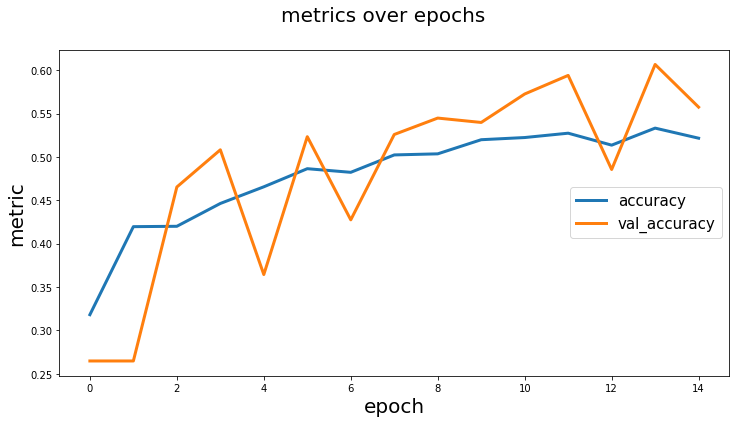

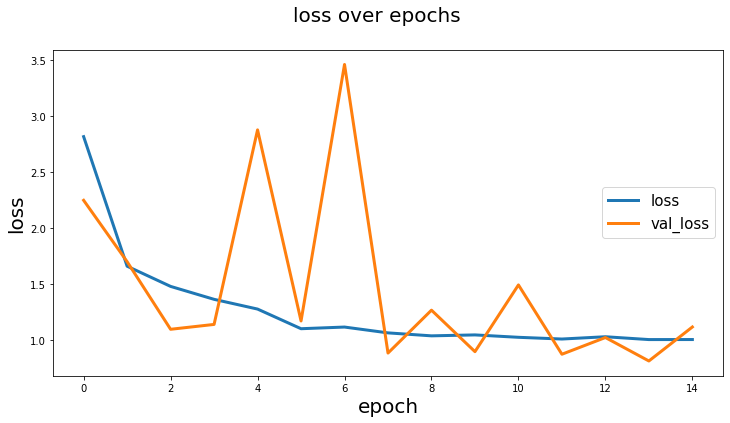

In [16]:
plot_segm_history(hist,metrics=['accuracy','val_accuracy'])

In [17]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(
        include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


In [18]:
model = build_model(num_classes=NUM_CLASSES)

In [19]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 3)  0           ['input_6[0][0]']                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 128, 128, 3)  0           ['sequential[3][0]']             
                                                                                                  
 normalization_3 (Normalization  (None, 128, 128, 3)  7          ['rescaling_3[0][0]'] 

In [20]:
epochs = 15
hist = model.fit(x_train, y_train, validation_data=(
    x_val, y_val), epochs=epochs, steps_per_epoch=150,  verbose=2)


Epoch 1/15
150/150 - 29s - loss: 1.4158 - accuracy: 0.7065 - val_loss: 0.4209 - val_accuracy: 0.8916 - 29s/epoch - 195ms/step
Epoch 2/15
150/150 - 18s - loss: 1.4240 - accuracy: 0.7470 - val_loss: 0.5407 - val_accuracy: 0.8890 - 18s/epoch - 121ms/step
Epoch 3/15
150/150 - 18s - loss: 1.3530 - accuracy: 0.7712 - val_loss: 0.8198 - val_accuracy: 0.8613 - 18s/epoch - 121ms/step
Epoch 4/15
150/150 - 18s - loss: 1.3059 - accuracy: 0.7687 - val_loss: 0.7126 - val_accuracy: 0.8689 - 18s/epoch - 121ms/step
Epoch 5/15
150/150 - 18s - loss: 1.2878 - accuracy: 0.7557 - val_loss: 0.6318 - val_accuracy: 0.8752 - 18s/epoch - 121ms/step
Epoch 6/15
150/150 - 18s - loss: 1.1832 - accuracy: 0.7691 - val_loss: 0.6620 - val_accuracy: 0.8726 - 18s/epoch - 121ms/step
Epoch 7/15
150/150 - 18s - loss: 1.1105 - accuracy: 0.7720 - val_loss: 0.7009 - val_accuracy: 0.8663 - 18s/epoch - 120ms/step
Epoch 8/15
150/150 - 18s - loss: 1.0338 - accuracy: 0.7875 - val_loss: 0.7278 - val_accuracy: 0.8285 - 18s/epoch - 121

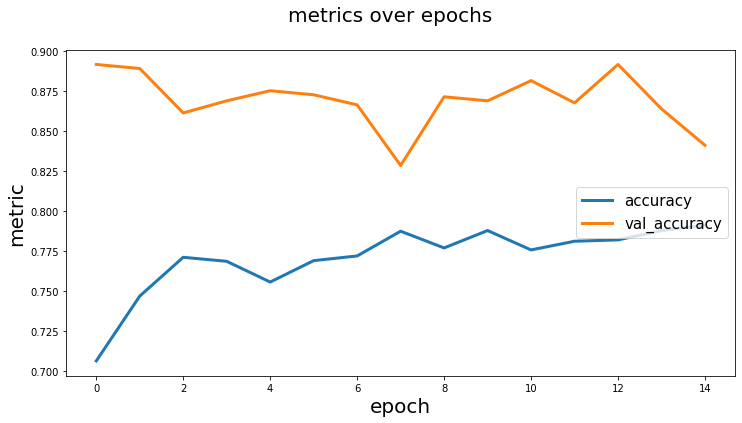

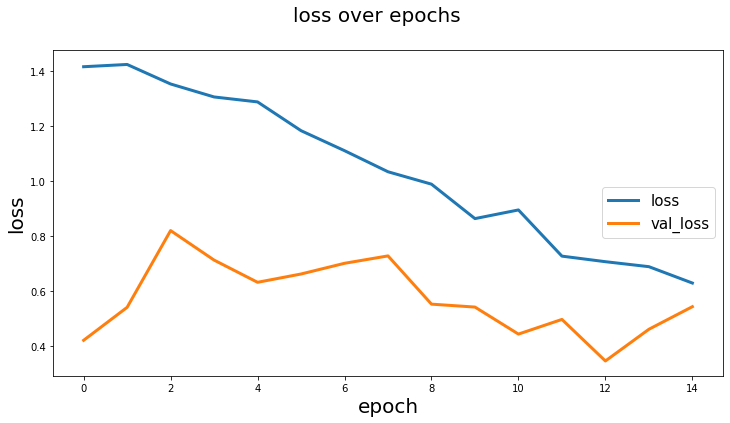

In [21]:
plot_segm_history(hist,metrics=['accuracy','val_accuracy'])

In [22]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)


In [23]:
epochs = 15
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, steps_per_epoch=150,  verbose=2)

Epoch 1/15
150/150 - 28s - loss: 0.5562 - accuracy: 0.8163 - val_loss: 0.3451 - val_accuracy: 0.8916 - 28s/epoch - 186ms/step
Epoch 2/15
150/150 - 20s - loss: 0.4505 - accuracy: 0.8463 - val_loss: 0.3233 - val_accuracy: 0.9029 - 20s/epoch - 132ms/step
Epoch 3/15
150/150 - 20s - loss: 0.4819 - accuracy: 0.8397 - val_loss: 0.3094 - val_accuracy: 0.9016 - 20s/epoch - 131ms/step
Epoch 4/15
150/150 - 20s - loss: 0.4203 - accuracy: 0.8459 - val_loss: 0.2984 - val_accuracy: 0.9079 - 20s/epoch - 131ms/step
Epoch 5/15
150/150 - 20s - loss: 0.3600 - accuracy: 0.8689 - val_loss: 0.2943 - val_accuracy: 0.9092 - 20s/epoch - 131ms/step
Epoch 6/15
150/150 - 20s - loss: 0.3797 - accuracy: 0.8639 - val_loss: 0.2631 - val_accuracy: 0.9193 - 20s/epoch - 131ms/step
Epoch 7/15
150/150 - 20s - loss: 0.3139 - accuracy: 0.8852 - val_loss: 0.2843 - val_accuracy: 0.9206 - 20s/epoch - 131ms/step
Epoch 8/15
150/150 - 20s - loss: 0.3075 - accuracy: 0.8898 - val_loss: 0.2743 - val_accuracy: 0.9180 - 20s/epoch - 131

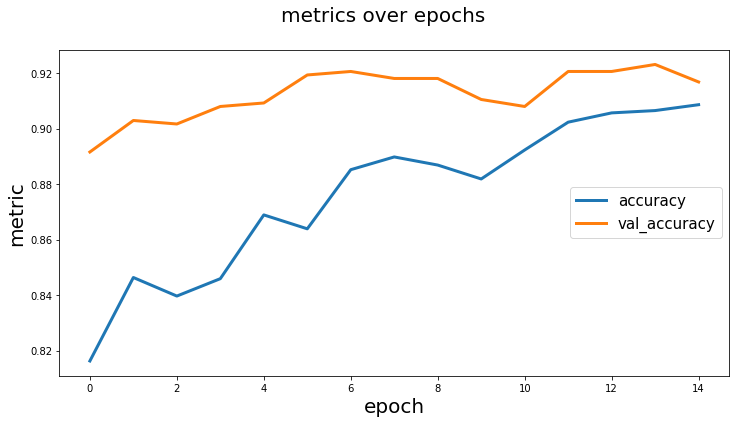

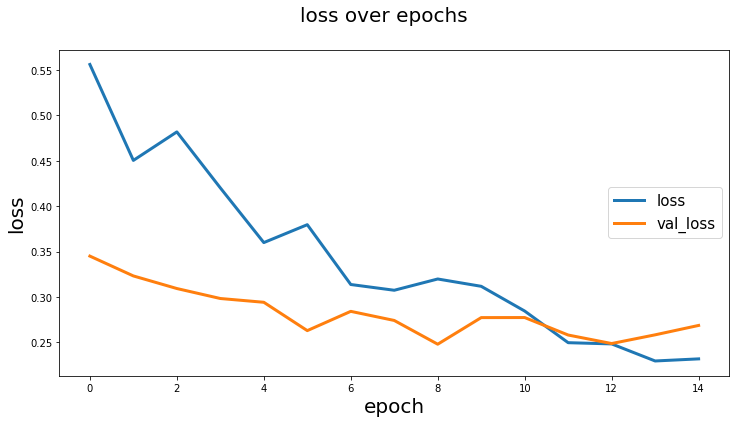

In [24]:
plot_segm_history(hist, metrics=['accuracy', 'val_accuracy'])

In [25]:
yp_train = model.predict(x_train)
yp_train = np.argmax(yp_train, axis=1)

yp_val = model.predict(x_val)
yp_val = np.argmax(yp_val, axis=1)

yp_test = model.predict(x_test)
yp_test = np.argmax(yp_test, axis=1)


In [26]:
y_train_value = np.argmax(y_train, axis=1)
y_val_value = np.argmax(y_val, axis=1)
y_test_value = np.argmax(y_test, axis=1)


In [27]:
def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):

    print("\n-----------------------------{}-----------------------------\n".format(name))

    labels = ['Cats', 'Dogs', 'Pizza', 'Not Pizza']
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train, display_labels=labels)
    s1 = round((cm_train[0, 0]/(cm_train[0, 0] + cm_train[0, 1])), 3)
    t1.plot()

    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train, target_names=labels))
    print("--------------------------------------------------------------------------")

    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val, display_labels=labels)
    s2 = round((cm_val[0, 0]/(cm_val[0, 0] + cm_val[0, 1])), 3)
    t2.plot()

    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val, target_names=labels))
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test, display_labels=labels)
    s3 = round((cm_test[0, 0]/(cm_test[0, 0] + cm_test[0, 1])), 3)
    t3.plot()

    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test, target_names=labels))
    print("--------------------------------------------------------------------------")



-----------------------------Convolution Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

        Cats       0.98      0.97      0.98       597
        Dogs       0.96      0.99      0.97       603
       Pizza       0.97      0.95      0.96       605
   Not Pizza       0.95      0.95      0.95       574

    accuracy                           0.97      2379
   macro avg       0.97      0.97      0.97      2379
weighted avg       0.97      0.97      0.97      2379

--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

        Cats       0.96      0.94      0.95       210
        Dogs       0.91      0.96      0.93       187
       Pizza       0.92      0.89      0.91       209
   Not Pizza       0.87      0.88      0.87       187

    accuracy                           0.92      

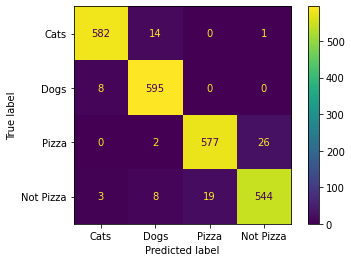

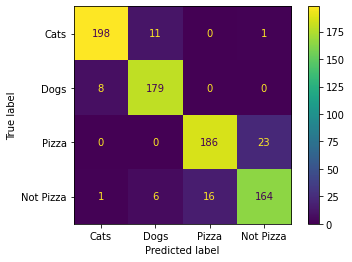

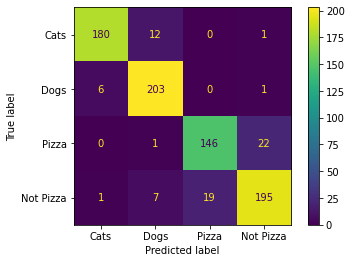

In [28]:
evaluation_parametrics("Convolution Neural Network", y_train_value,
                       yp_train, y_val_value, yp_val, y_test_value, yp_test)


In [29]:
train_score = model.evaluate(x_train, y_train, verbose=0)
val_score = model.evaluate(x_val, y_val, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)


In [46]:
print('Train loss:', "{:.2f}".format(train_score[0]))
print('Train accuracy:', "{:.2f}".format(train_score[1]))
print('----------------------------------------')
print('Validation loss:', "{:.2f}".format(val_score[0]))
print('Validation accuracy:', "{:.2f}".format(val_score[1]))
print('----------------------------------------')
print('Test loss:', "{:.2f}".format(test_score[0]))
print('Test accuracy:', "{:.2f}".format(test_score[1]))


Train loss: 0.09
Train accuracy: 0.97
----------------------------------------
Validation loss: 0.27
Validation accuracy: 0.92
----------------------------------------
Test loss: 0.28
Test accuracy: 0.91
